In [59]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import (
    C_adj,
    F_adj,
    ForwardModel,
    MaskedForwardModel,
)
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[8])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


def data_transform_gt(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[1])
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)
dataset_gt = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-homes/nmrgrp/nmr219/ese5934_project/data"),
    transform=data_transform_gt,
    challenge="multicoil",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PSNR, SSIM, NMSE, and NMI Alternative

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


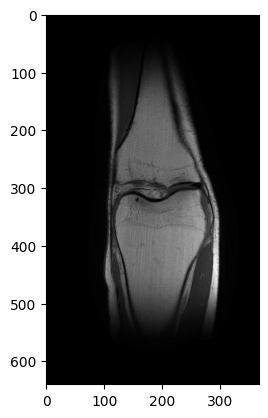

In [63]:
import numpy as np
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

kspace, (mean, std), masked_kspace, mask, csm = dataset_gt[15]
f_adj = F_adj()
c_adj = C_adj()
image_gt = c_adj(f_adj(kspace), csm)
ground_truth_image = image_gt.squeeze()
from matplotlib import pyplot as plt

plt.imshow(torch.view_as_complex(image_gt).abs()[0], cmap="gray")

# Grid Field (Voxel Representation)

In [56]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.001)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [57]:
params, image_list_ADAM = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=torch.device("cuda"),
)

iteration 1, dc_loss: 2.9849395751953125, tv_loss: 0.0
iteration 2, dc_loss: 2.98433518409729, tv_loss: 5.1339618948986754e-05
iteration 3, dc_loss: 2.983743667602539, tv_loss: 9.501633758191019e-05
iteration 4, dc_loss: 2.983156681060791, tv_loss: 0.00012607351527549326
iteration 5, dc_loss: 2.9825708866119385, tv_loss: 0.00015609718684572726
iteration 6, dc_loss: 2.9819858074188232, tv_loss: 0.0001877933827927336
iteration 7, dc_loss: 2.981401205062866, tv_loss: 0.00021926770568825305
iteration 8, dc_loss: 2.9808168411254883, tv_loss: 0.0002503482101019472
iteration 9, dc_loss: 2.9802324771881104, tv_loss: 0.0002812263264786452
iteration 10, dc_loss: 2.9796485900878906, tv_loss: 0.00031193712493404746
iteration 11, dc_loss: 2.979064702987671, tv_loss: 0.0003425805189181119
iteration 12, dc_loss: 2.978480577468872, tv_loss: 0.0003731456527020782
iteration 13, dc_loss: 2.9778969287872314, tv_loss: 0.0004038218467030674
iteration 14, dc_loss: 2.9773130416870117, tv_loss: 0.0004346325004

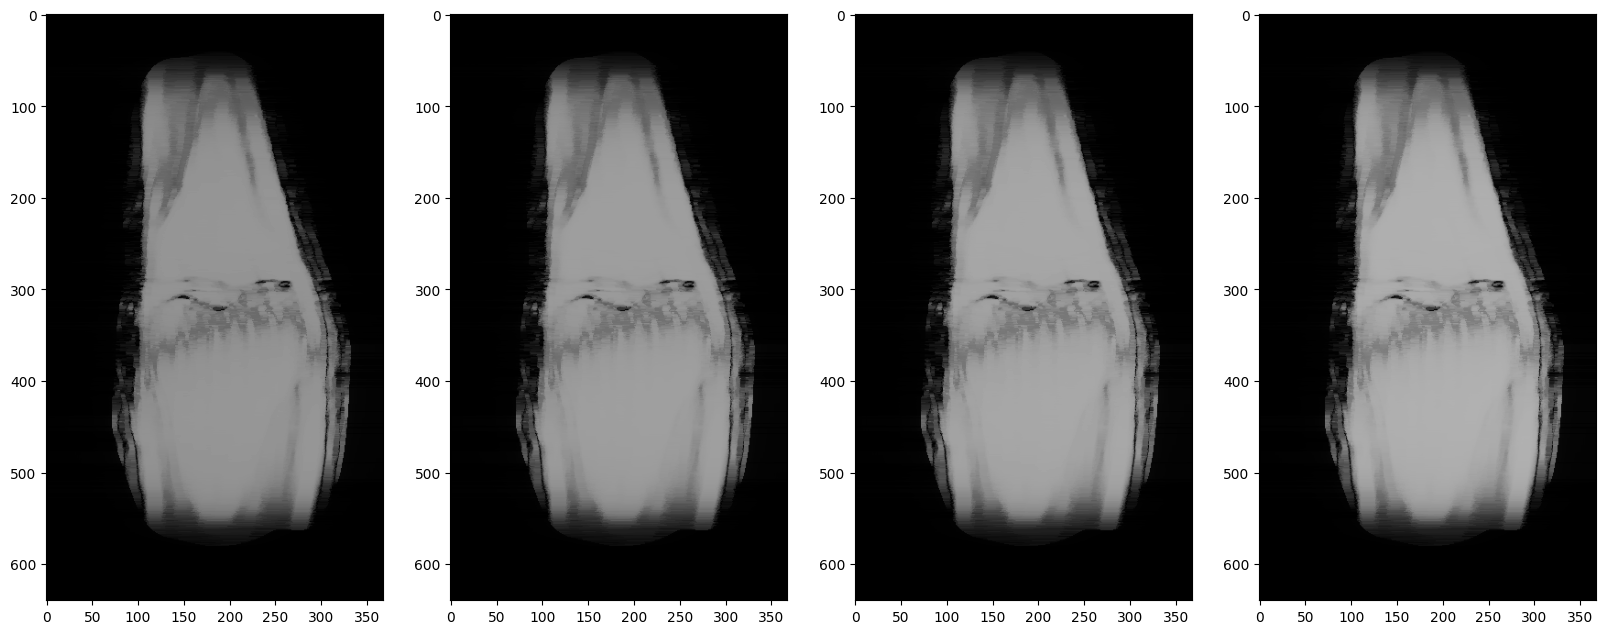

In [58]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list_ADAM[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray", vmax=2)

# SIREN

In [47]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=128,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-3)
# 1e-4 1.092077389
# 1e-3 0.08540542

/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [52]:
params, image_list_SIREN = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=1000,
    device=device,
)

iteration 1, dc_loss: 0.046031683683395386, tv_loss: 0.2800038754940033
iteration 2, dc_loss: 0.45890066027641296, tv_loss: 0.3782409131526947
iteration 3, dc_loss: 0.2323078215122223, tv_loss: 0.4126953184604645
iteration 4, dc_loss: 0.20789507031440735, tv_loss: 0.4941785931587219
iteration 5, dc_loss: 0.15510237216949463, tv_loss: 0.3339126408100128
iteration 6, dc_loss: 0.1449359655380249, tv_loss: 0.33383432030677795
iteration 7, dc_loss: 0.11993062496185303, tv_loss: 0.32958221435546875
iteration 8, dc_loss: 0.10427981615066528, tv_loss: 0.340960830450058
iteration 9, dc_loss: 0.09909551590681076, tv_loss: 0.32437601685523987
iteration 10, dc_loss: 0.09777048975229263, tv_loss: 0.32227540016174316
iteration 11, dc_loss: 0.09252213686704636, tv_loss: 0.3114260137081146
iteration 12, dc_loss: 0.08727513998746872, tv_loss: 0.31578707695007324
iteration 13, dc_loss: 0.08165675401687622, tv_loss: 0.3088851869106293
iteration 14, dc_loss: 0.07882773131132126, tv_loss: 0.310232281684875

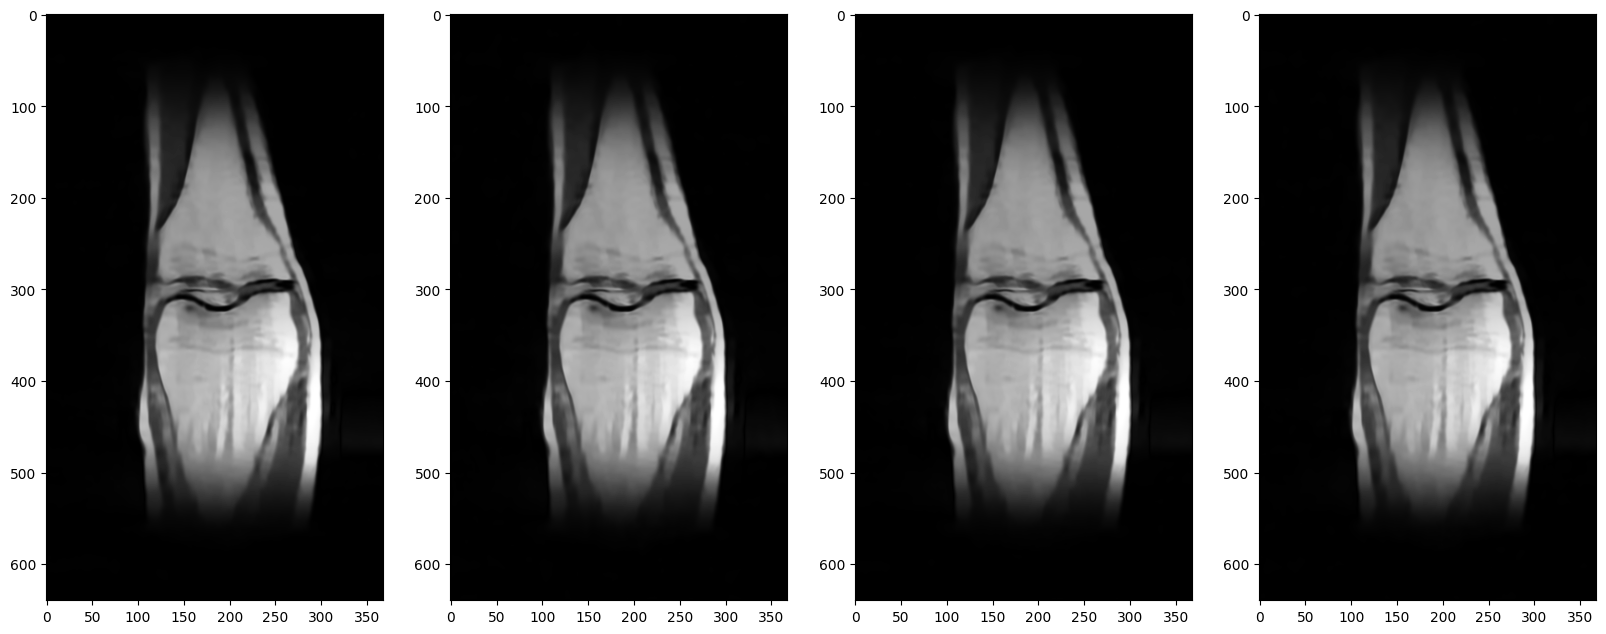

In [53]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
for i, image in enumerate(image_list[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")

In [60]:
print(predicted_image_ADAM.shape)

torch.Size([640, 368, 2])


In [66]:
print(predicted_image_SIREN.shape)
print(ground_truth_image.shape)

torch.Size([640, 368, 2])
torch.Size([640, 368, 2])


In [77]:
import re

predicted_image_ADAM = image_list_ADAM[-1]
predicted_image_SIREN = image_list_SIREN[-1]
gt_np = torch.view_as_complex(ground_truth_image).abs().cpu().numpy()
pred_np_Adam = torch.view_as_complex(predicted_image_ADAM).abs().cpu().numpy()
pred_np_Siren = torch.view_as_complex(predicted_image_SIREN).abs().cpu().numpy()


def rescale_image(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image


def all_number(image, gt):
    return psnr(gt, image, data_range=255), nrmse(gt, image)


# Rescale the values to [0, 255]
# gt_np = ((gt_np - gt_np.min()) / (gt_np.max() - gt_np.min())).astype(np.uint8)
# pred_np = (
#     (pred_np_Siren - pred_np_Siren.min())
#     / (pred_np_Siren.max() - pred_np_Siren.min())
#     * 255
# ).astype(np.uint8)

pred_np_Siren = rescale_image(pred_np_Siren)
pred_np_Adam = rescale_image(pred_np_Adam)
gt_np = rescale_image(gt_np)

print(all_number(pred_np_Siren, gt_np))
print(all_number(pred_np_Adam, gt_np))
# Convert to grayscale if necessary
# gt_gray = np.mean(gt_np, axis=2)#I don't think it's converting the image to gray scale
# pred_gray = np.mean(pred_np, axis=2)

# By taking the mean across the color channels, this method essentially converts the color image into grayscale by preserving the luminance information. Each pixel in the resulting grayscale image represents the average intensity of the corresponding pixel in the original color image.

# Calculate PSNR
# psnr_value = psnr(gt_np, pred_np, data_range=255)
# psnr_value = psnr(gt_np, pred_np_Siren)
# psnr_value = psnr(gt_gray, pred_gray, data_range=255)


# Calculate NRMSE
# nrmse_value = nrmse(gt_np, pred_np_Siren)
# nrmse_value = nrmse(gt_gray, pred_gray)

# Calculate SSIM
# ssim_value, ssim_map = ssim(gt_np, pred_np_Siren, channel_axis=2, full=True)
# ssim_value, ssim_map = ssim(gt_gray, pred_gray, data_range=255,full=True)
# ssim_value, ssim_map = ssim(gt_np, pred_np,data_range=255,channel_axis=2,full=True)

# Calculate normalized mutual information
# nmi_value = nmi(gt_np, pred_np_Siren, bins=100)


# print("PSNR:", psnr_value)
# print("NRMSE:", nrmse_value)
# print("SSIM:", ssim_value)
# print("SSIM Map:", ssim_map)
# print("Normalized Mutual Information:", nmi_value)

(20.63321594456836, 0.4568541707170111)
(8.404033153648523, 1.867397330252236)


# DictField

In [3]:
import numpy as np
from omegaconf import OmegaConf

# from torch.utils.data import DataLoader
# from datalo

base_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/defaults.yaml")
second_conf = OmegaConf.load("/bmrc-an-data/Chunxu/ese5934_project/configs/image.yaml")
cfg = OmegaConf.merge(
    base_conf,
    second_conf,
)

In [4]:
cfg["model"]

{'basis_dims': [32, 32, 32, 16, 16, 16], 'coeff_reso': 32, 'total_params': 1024000, 'T_basis': 0, 'T_coeff': 0, 'coef_init': 0.001, 'coef_mode': 'bilinear', 'basis_mode': 'bilinear', 'freq_bands': [2.0, 3.2, 4.4, 5.6, 6.8, 8.0], 'basis_mapping': 'sawtooth', 'with_dropout': True, 'in_dim': 2, 'out_dim': 2, 'num_layers': 2, 'hidden_dim': 64, 'basis_resos': [64, 101, 140, 179, 217, 259], 'coeff_type': 'grid', 'basis_type': 'grid'}

In [60]:
from ese5934_project.models.FactorFields import DictField

device = torch.device("cuda:0")
size = (640, 368)
model = DictField(cfg, size, device)

ic| self.basis_dims: array([32, 32, 32, 16, 16, 16])
ic| self.basis_reso: array([ 64, 101, 140, 179, 217, 259])
ic| self.basis_reso_y: array([ 37.,  58.,  80., 103., 125., 149.])
ic| self.freq_bands: tensor([10.0000,  6.3366,  4.5714,  3.5754,  2.9493,  2.4710], device='cuda:0

')
ic| self.bbox: tensor([[  0.,   0.],
                       [640., 368.]], device='cuda:0')
ic| self.coeff_reso: [11, 7]
ic| coeffs.shape: torch.Size([1, 144, 11, 7])
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 64, 64]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 101, 101]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 32, 140, 140]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 179, 179]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 217, 217]
ic| [1, basis_dim] + [reso] * self.in_dim: [1, 16, 259, 259]


=====> total parameters:  3444576


In [61]:
from ese5934_project.models.FactorFields import get_coordinates

coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
optimizer = torchopt.adamw(lr=1e-3)

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])


Done.


In [62]:
params, image_list = reconstruct(
    model,
    coords,
    masked_kspace,
    csm,
    mask,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)

ic| params.keys(): dict_keys(['coeffs', 'basises.0', 'basises.1', 'basises.2', 'basises.3', 'basises.4', 'basises.5', 'linear_mat.backbone.0.weight', 'linear_mat.backbone.0.bias', 'linear_mat.backbone.1.weight'])


iteration 1, dc_loss: 2.9578633308410645, tv_loss: 0.0016996804624795914
iteration 2, dc_loss: 2.956383466720581, tv_loss: 0.0011721047339960933
iteration 3, dc_loss: 2.954906463623047, tv_loss: 0.0006454677204601467
iteration 4, dc_loss: 2.95343279838562, tv_loss: 0.00011935881775571033
iteration 5, dc_loss: 2.9519615173339844, tv_loss: 0.0004068722191732377


iteration 6, dc_loss: 2.9505670070648193, tv_loss: 0.0008764000958763063
iteration 7, dc_loss: 2.9492242336273193, tv_loss: 0.0013025006046518683
iteration 8, dc_loss: 2.9479188919067383, tv_loss: 0.0016951384022831917
iteration 9, dc_loss: 2.9466419219970703, tv_loss: 0.002061116509139538
iteration 10, dc_loss: 2.9453859329223633, tv_loss: 0.0024053503293544054
iteration 11, dc_loss: 2.9441471099853516, tv_loss: 0.0027315490879118443
iteration 12, dc_loss: 2.9429380893707275, tv_loss: 0.003034691559150815
iteration 13, dc_loss: 2.941751480102539, tv_loss: 0.003319093259051442
iteration 14, dc_loss: 2.940570592880249, tv_loss: 0.003592831315472722
iteration 15, dc_loss: 2.9394140243530273, tv_loss: 0.0038554277271032333
iteration 16, dc_loss: 2.9382708072662354, tv_loss: 0.004109060391783714
iteration 17, dc_loss: 2.937127113342285, tv_loss: 0.004356077406555414
iteration 18, dc_loss: 2.935981035232544, tv_loss: 0.004597424063831568
iteration 19, dc_loss: 2.9348316192626953, tv_loss: 0

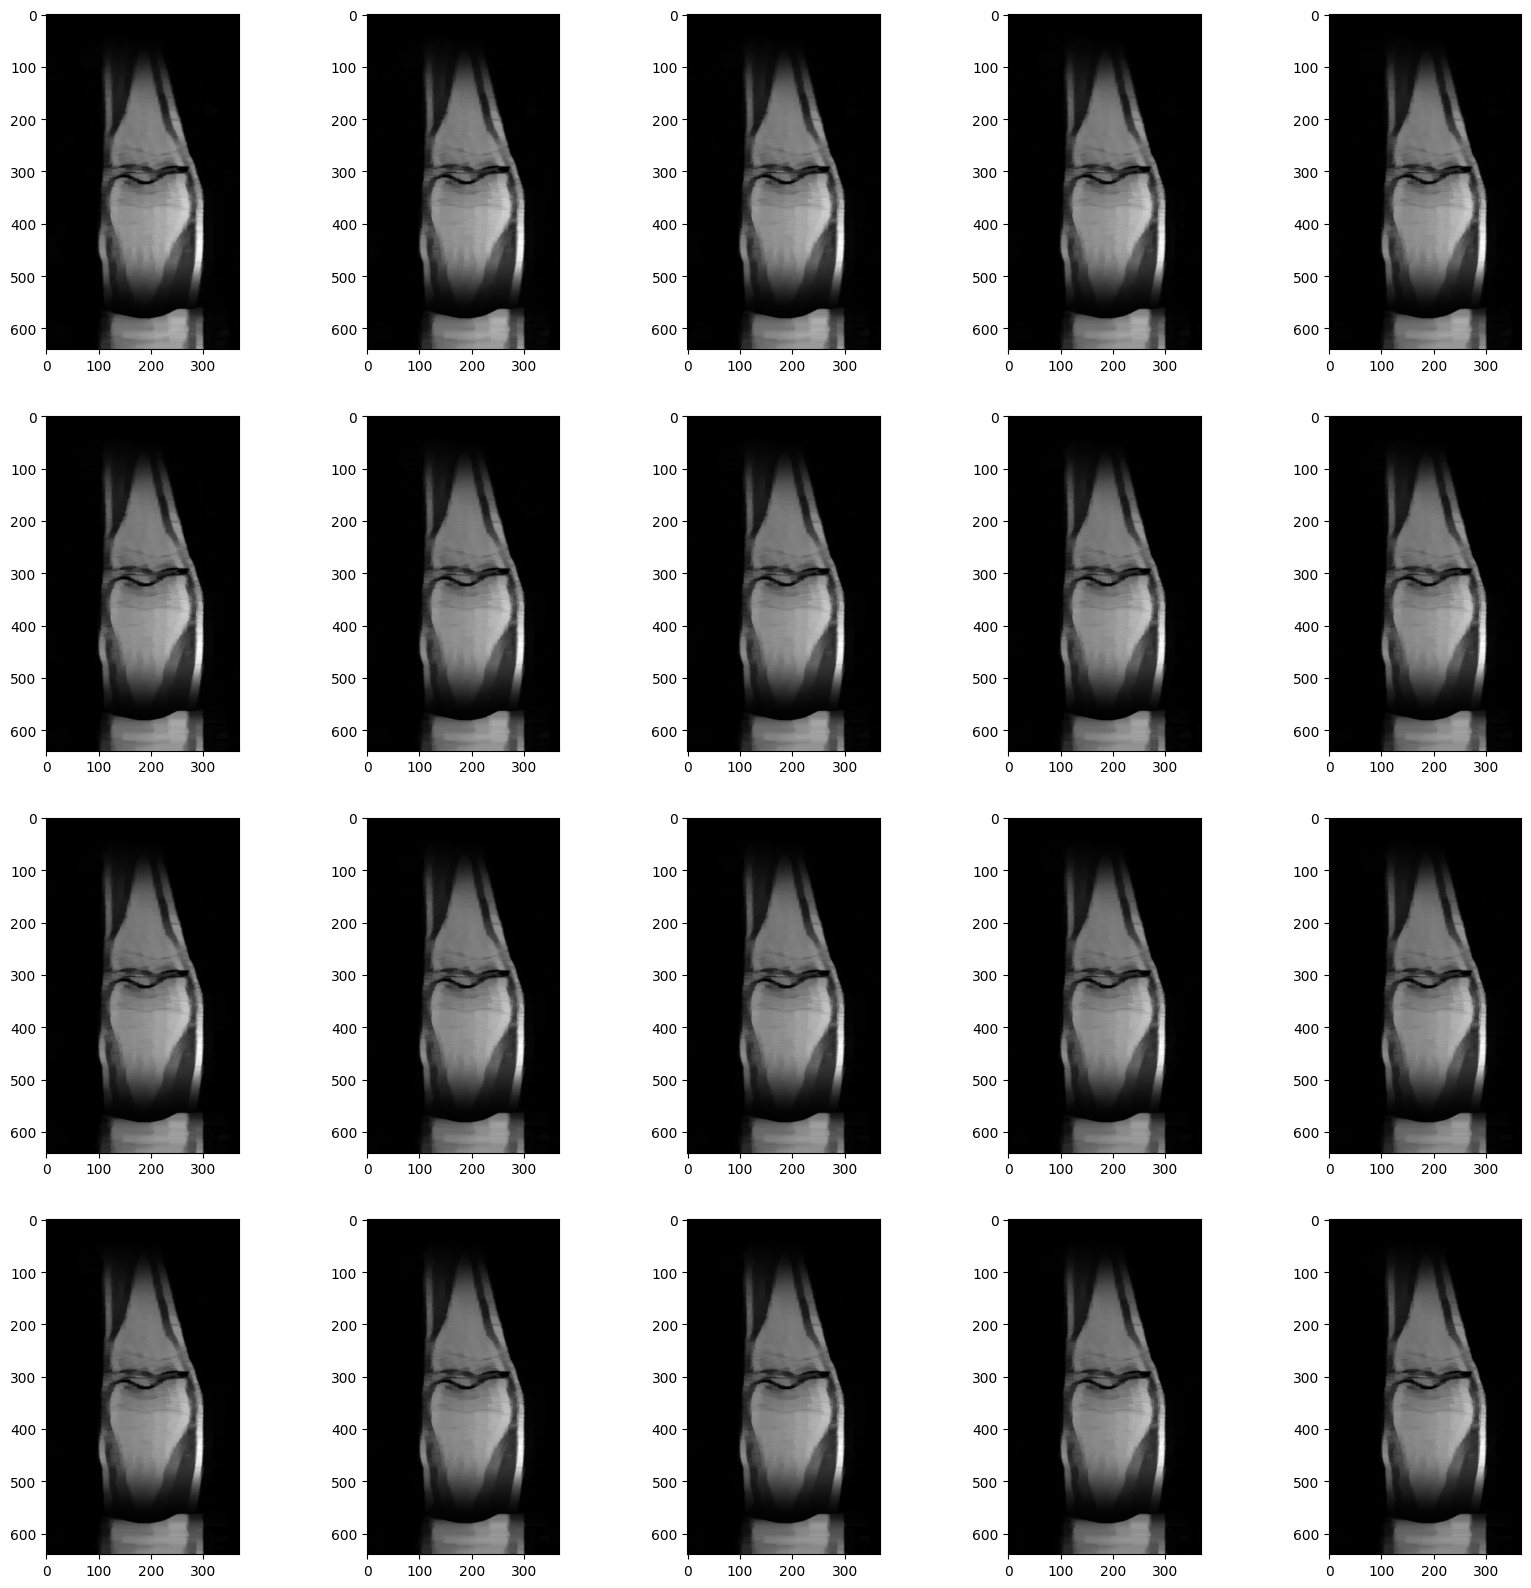

In [63]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(image_list[-20:]):
    axs[i // 5, i % 5].imshow(complex_abs(image), cmap="gray")

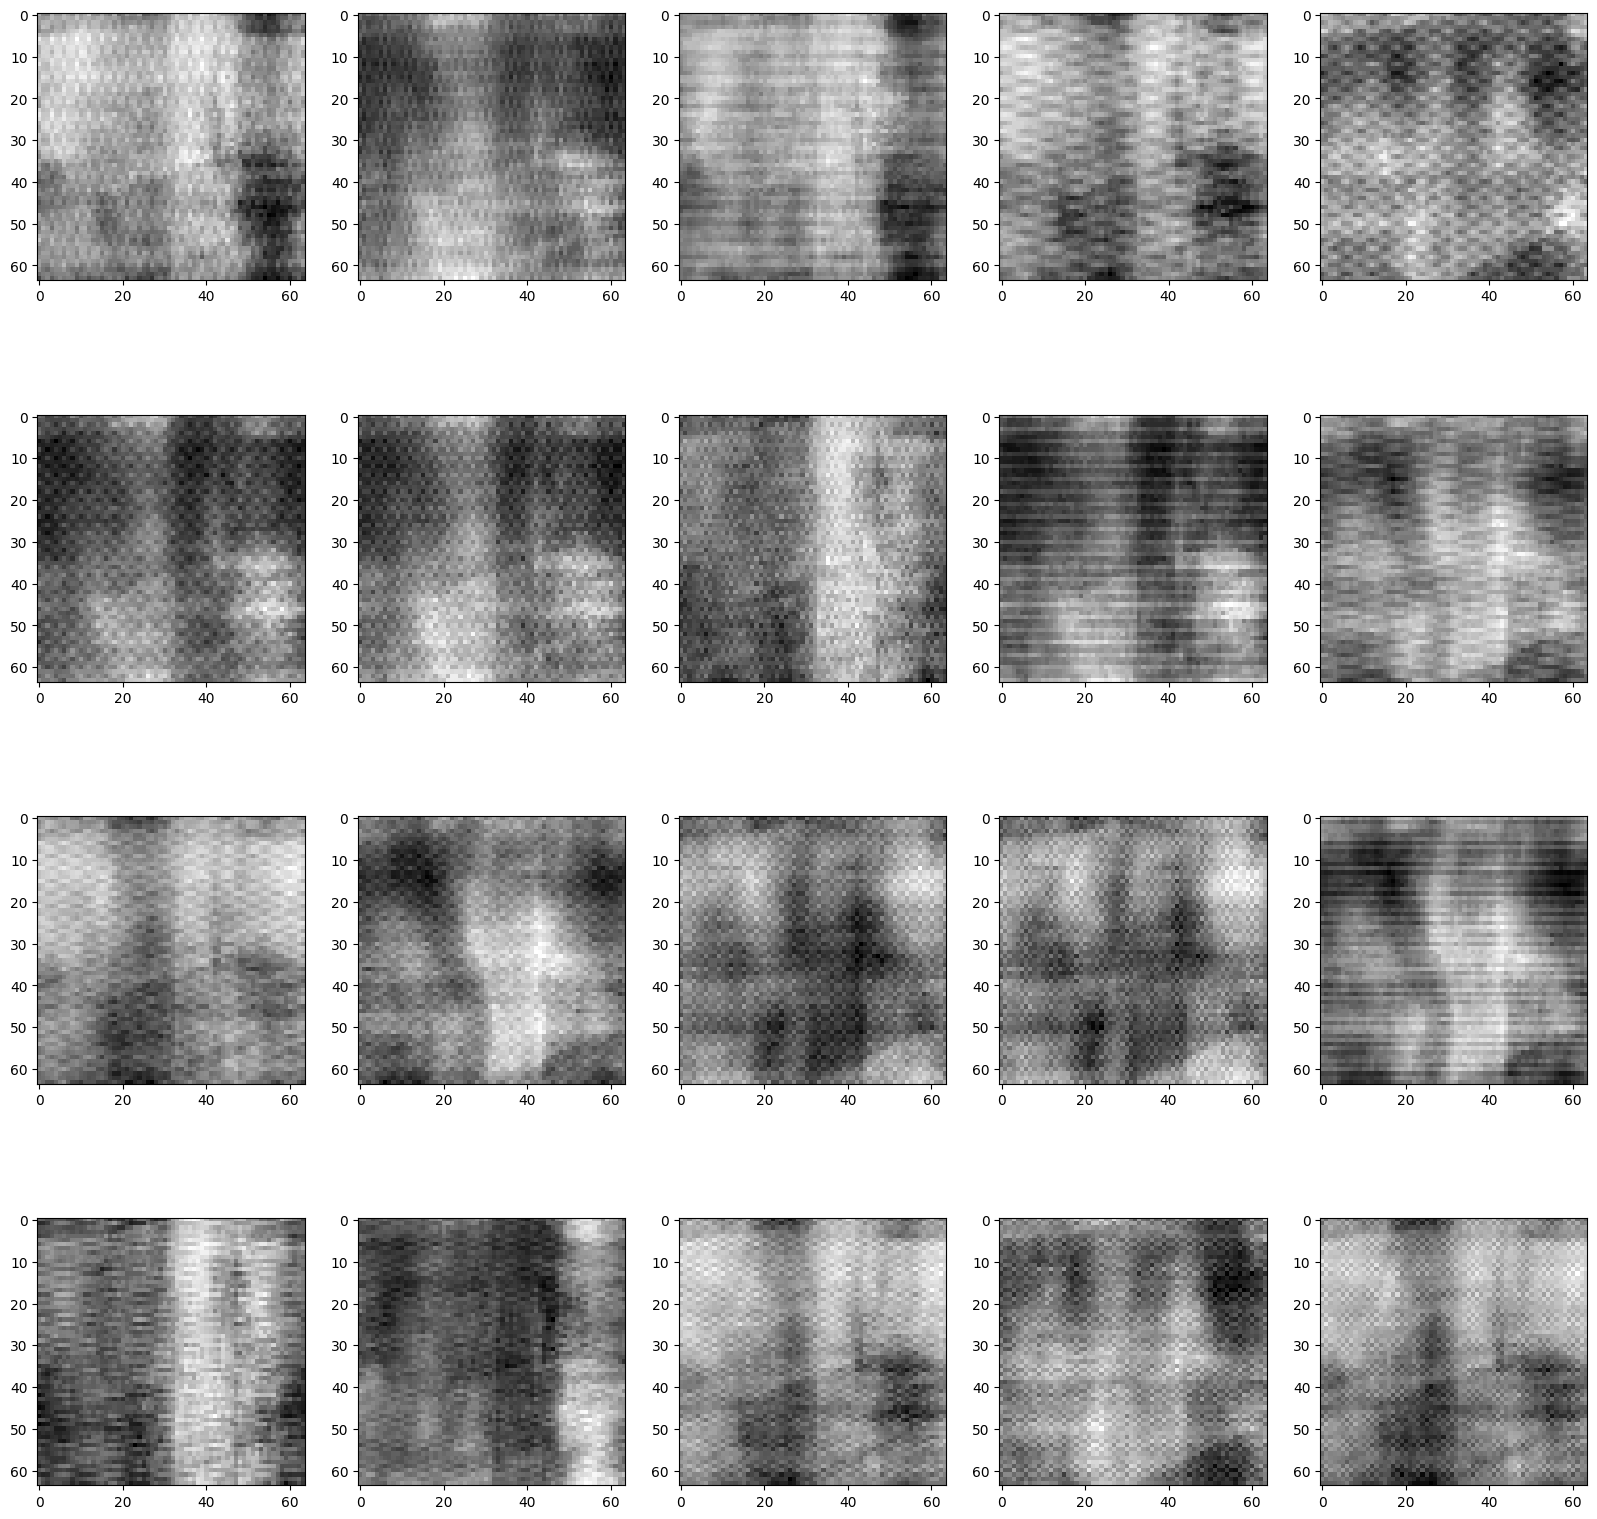

In [47]:
model.basises[0].shape
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(model.basises[0][0, -20:]):
    axs[i // 5, i % 5].imshow(image.numpy(force=True), cmap="gray")

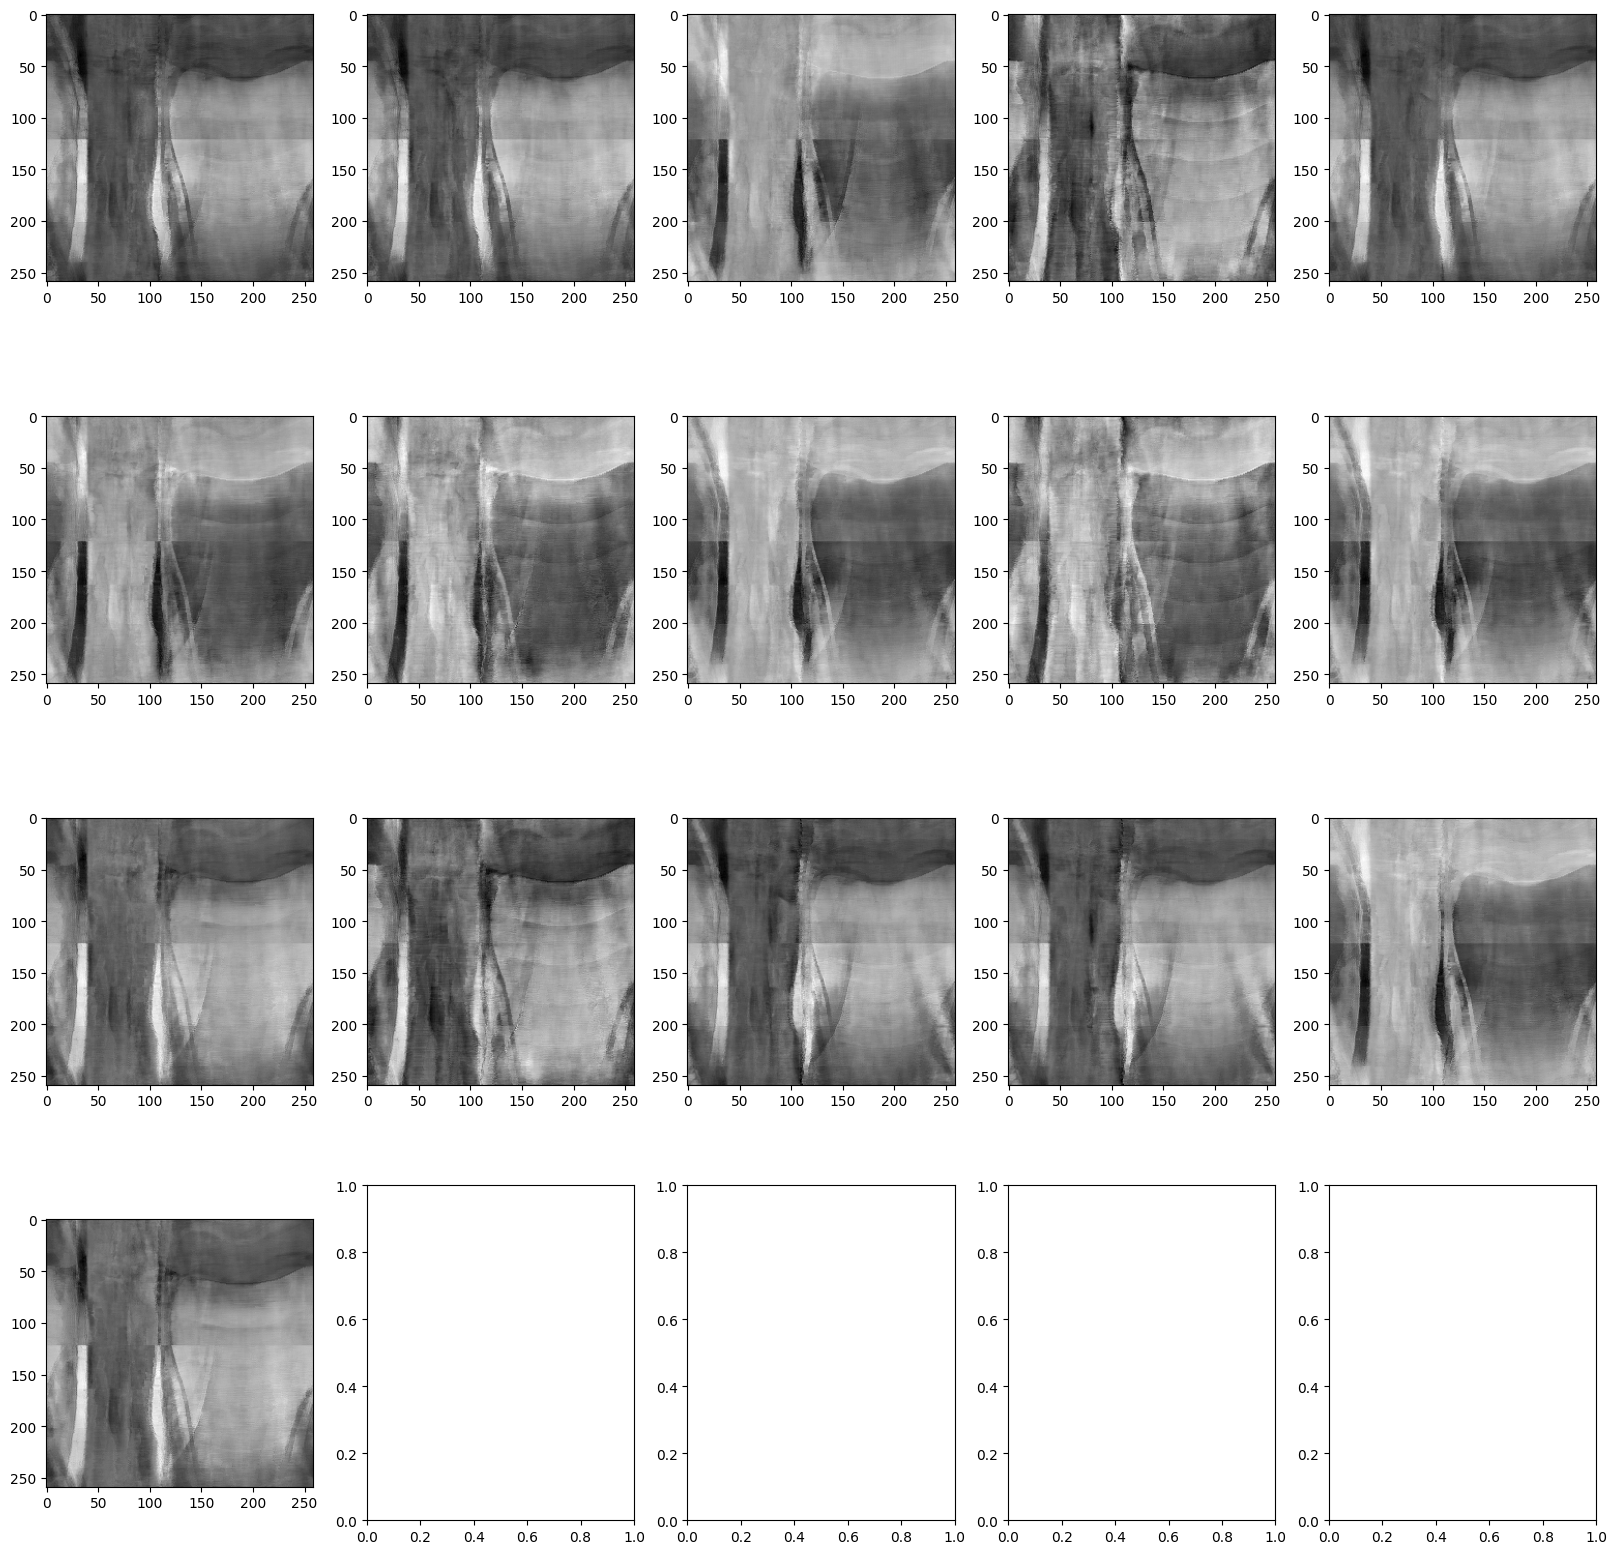

In [50]:
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
for i, image in enumerate(model.basises[5][0, -20:]):
    axs[i // 5, i % 5].imshow(image.numpy(force=True), cmap="gray")

In [51]:
model.coeffs.shape

torch.Size([1, 144, 11, 7])

IndexError: index 4 is out of bounds for axis 0 with size 4

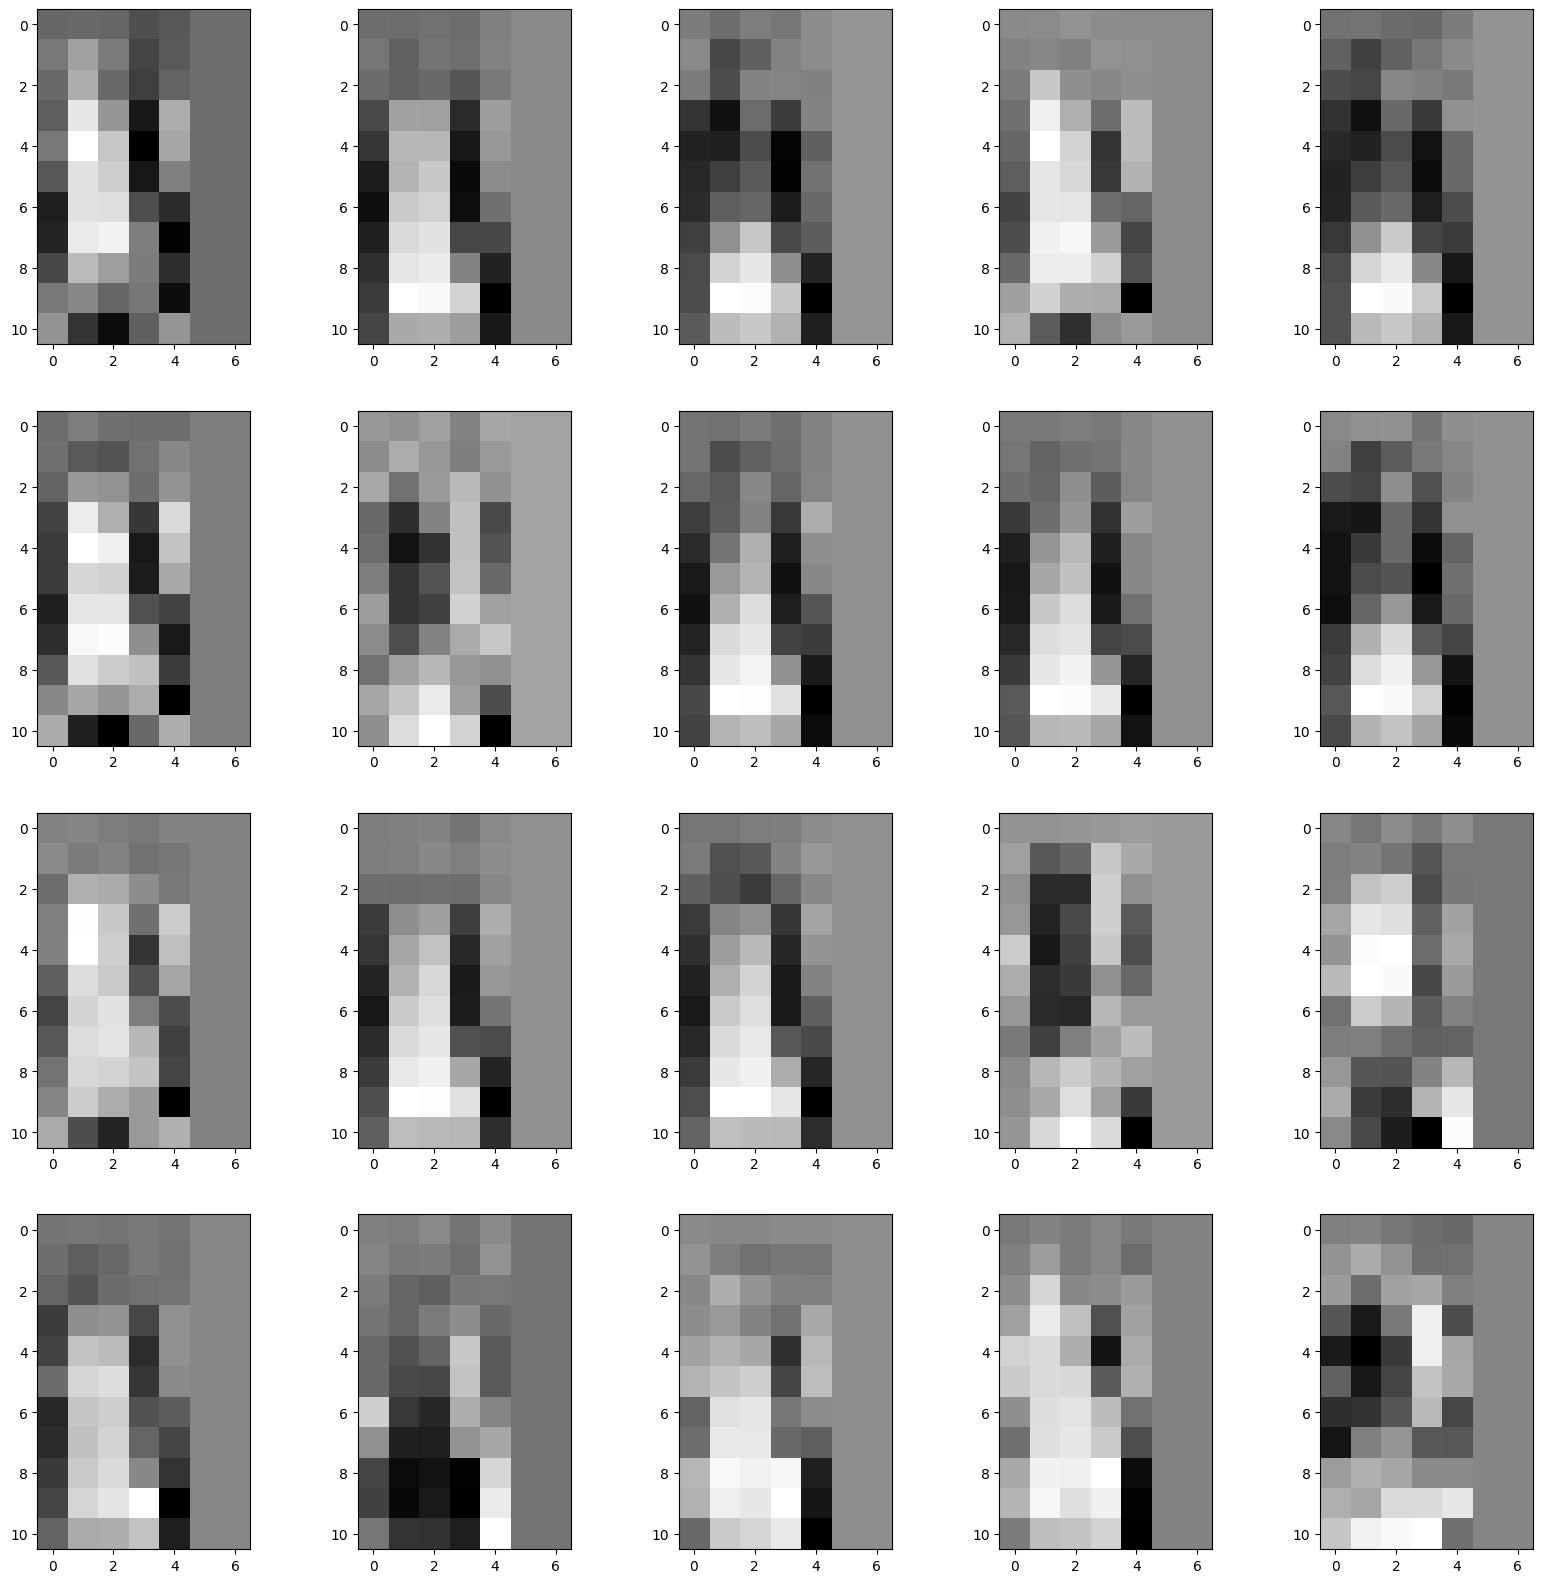

In [58]:
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
i = 0
for i, image in enumerate(model.coeffs[0, i + 0 : 144 : 7]):
    axs[i // 5, i % 5].imshow(image.numpy(force=True), cmap="gray")